title: Debt Collection Agency Performance Analysis  
author: Jesse Scherwitz  
date: 2022-04-28  
region: EU  
link: https://docs.google.com/presentation/d/16TcMkkXhAuYhgHtQRVOPS6NNPeMd2Y-y32hn8G3_-M8/edit?usp=sharing  
tags: DCA, debt_collection, collection, dunning, pair, knp, eos, germany, recovery_rate, cohorts, overdraft, credit  
summary: We look into recovery rates, share of recovered cases and speed of action and compare 3 debt collection agencies in the German Market over a timeframe of 5-6 months to decide which agency we should partner with. Primary goal is to maximise € recoveries resulting writeoffs all types of defaulting customers (all debt types / credit products considered). Pair performs strongest with respect to all 3 metrics, most importantly shows significantly highest overall recovery rate (10.7%) compared to the second place eos (7.9%). Pair's recovery rate is high across all cohorts and on all debt buckets, especially on the financially relevant bucket 2500-10000€. In addition, pair manages to recover first payments per case the quickest on average, and across all buckets. Share of recovered cases is roughly on par with knp. Overall recommendation is therefore to go with pair. This could lead to additional annual recoveries of estimated ~200k€ based on the observed 2.72% delta in recovery rate (note that the annual delta might be even higher) and last year's handover amount €.

In [426]:
!pip install seaborn

You should consider upgrading via the '/usr/local/bin/python -m pip install --upgrade pip' command.


In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from collections import Counter
from datetime import datetime

### Some specifications for plots



In [11]:
color_map = {
    "pair": (0.4, 0.7607843137254902, 0.6470588235294118),
    "eos": (0.9882352941176471, 0.5529411764705883, 0.3843137254901961),
    "knp": (0.5529411764705883, 0.6274509803921569, 0.796078431372549),
}

In [12]:
sns.set(rc={"figure.figsize": (16, 8)})

## Recovery Data

In [138]:
knp = pd.read_csv(
    "fra/live/2022-04_Bestandsbericht_Full_(added_collection_id_corrected_installments)_v1.4.csv",
    delimiter=";",
)

eos_hist = pd.read_csv(
    "fra/live/bestandsbericht_files/output/EOS_Bestandsbericht_historical.csv"
)
eos_2022 = pd.read_csv(
    "fra/live/bestandsbericht_files/EOS_Bestandsbericht_20220228.csv"
)
eos_2 = pd.read_csv(
    "fra/live/EOS_Bestandsbericht_2022-Upload_03.2022_EOS - EOS_Bestandsbericht_2022-Upload_03.2022_EOS.csv"
)


pair = pd.read_csv(
    "fra/live/bestandsbericht_files/output/PAIR_Bestandsbericht_historical.csv"
)
pair_2 = pd.read_csv(
    "fra/live/Pair_Bestandsbericht_2021-Upload_03.2022_Pair_ - Pair_Bestandsbericht_2021-Upload_03.2022_Pair_.csv"
)

/usr/local/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3524: DtypeWarning: Columns (3) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


In [139]:
eos_2022 = eos_2022[eos_hist.columns]
eos_2 = eos_2[eos_hist.columns]

eos = pd.concat([eos_hist, eos_2022, eos_2], ignore_index=True).drop_duplicates()
pair = pd.concat([pair, pair_2], ignore_index=True).drop_duplicates()

knp["agency"] = "knp"
eos["agency"] = "eos"
pair["agency"] = "pair"

all_data = pd.concat([knp, eos, pair], ignore_index=True)

all_data = all_data.rename(
    columns={"reason": "debt_type", "main_claim_handover": "amount"}
)
all_data = all_data[all_data.handover_date >= "2021-09-22"]

# 1 error in data
all_data = all_data[all_data.handover_date <= all_data.payment_date]

all_data["pay_month"] = all_data["payment_date"].astype(str).str[:7]

all_data.head(0)

,mandant,order_number,Reason,collection_id,user_id,claim_number,phase,handover_date,collection_status,action,...,instalment_status,instalment_agreed_n,instalment_agreed_amount,main_claim_payment,main_claim_open,payment_date,main_claim_payment_accumulated,agency,debt_type,pay_month


In [140]:
end_ts = "2022-03-31"

all_data = all_data[all_data.payment_date <= end_ts]

all_data["payment_date"] = pd.to_datetime(all_data["payment_date"])
all_data["handover_date"] = pd.to_datetime(all_data["handover_date"])

all_data = all_data.reset_index(drop=True)

### Recoveries over Time

<AxesSubplot:xlabel='payment_date', ylabel='agency'>

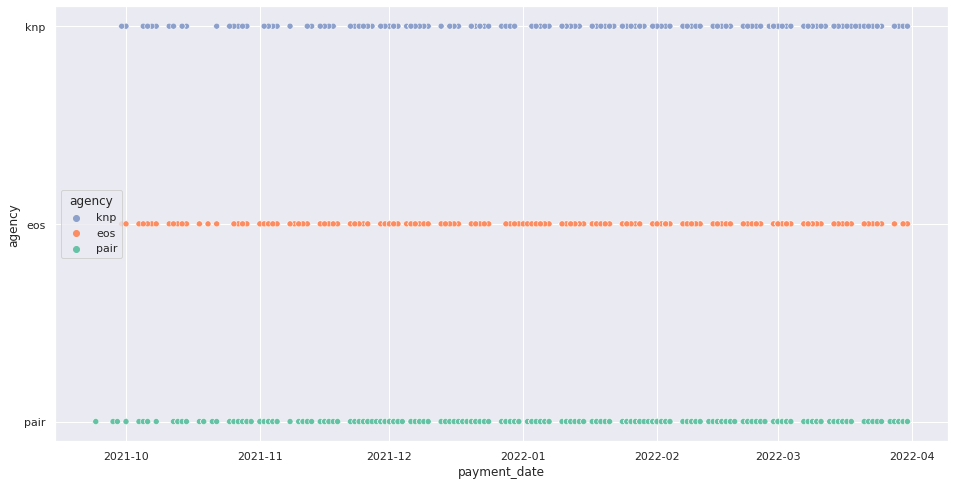

In [293]:
sns.scatterplot(
    data=all_data[["payment_date", "agency"]],
    x="payment_date",
    y="agency",
    hue="agency",
    palette=color_map,
)

## Handover Data - Only Test Users

In [141]:
users = pd.read_csv("fra/live/german_dc_test_.csv")

"""

select
    dwh_dunning_handovers.*
from dwh_dunning_handovers
inner join etl_reporting.cmd_address as addr
	on dwh_dunning_handovers.user_id = addr.user_id
	and addr."type" = 'SHIPPING'
    and addr.country = 'DEU'
where true
  and dwh_dunning_handovers.created > '2021-09-22'

"""

'\n\nselect\n    dwh_dunning_handovers.*\nfrom dwh_dunning_handovers\ninner join etl_reporting.cmd_address as addr\n\ton dwh_dunning_handovers.user_id = addr.user_id\n\tand addr."type" = \'SHIPPING\'\n    and addr.country = \'DEU\'\nwhere true\n  and dwh_dunning_handovers.created > \'2021-09-22\'\n\n'

In [142]:
users = users[users.created < "2022-03-01"]

users["created_date"] = users["created"].astype(str).str[:10]
users["created_date"] = pd.to_datetime(users["created_date"])
users["created"] = pd.to_datetime(users["created"])

## Handover Data Quick Analysis

<AxesSubplot:xlabel='created_date', ylabel='agency'>

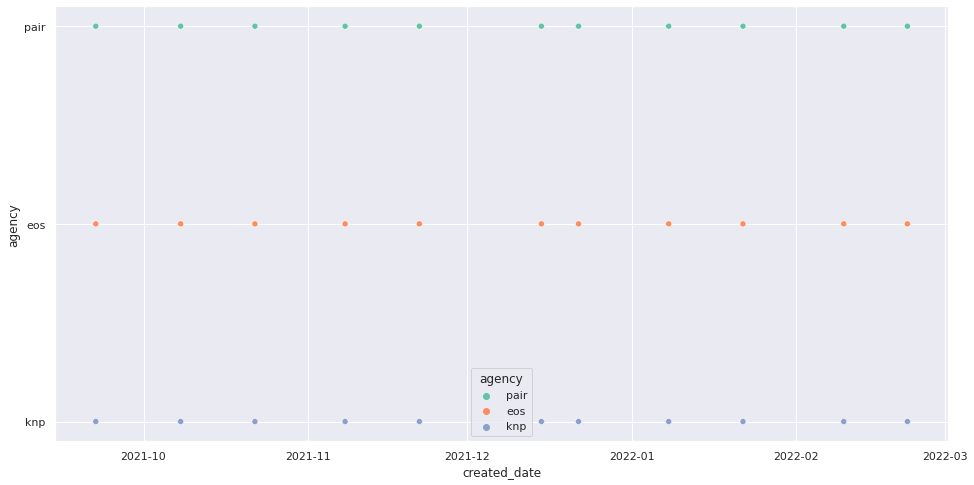

In [143]:
sns.scatterplot(
    data=users[["created_date", "agency"]],
    x="created_date",
    y="agency",
    hue="agency",
    palette=color_map,
)

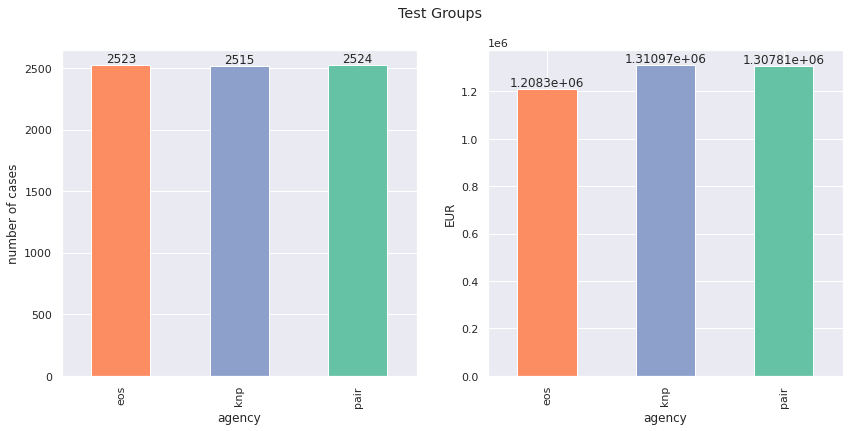

In [144]:
agg_users = users[["user_id", "agency"]].groupby(by="agency").size()
y = users[["amount", "agency"]].groupby(by="agency").sum().squeeze()

fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(14, 6))

agg_users.plot(kind="bar", color=y.index.map(color_map), ax=ax[0])
y.plot(kind="bar", color=y.index.map(color_map), ax=ax[1])

for k in range(2):
    for container in ax[k].containers:
        ax[k].bar_label(container)

ax[0].set_ylabel("number of cases")
ax[1].set_ylabel("EUR")
fig.suptitle("Test Groups")
plt.show()

### Look at Buckets

In [145]:
def bucket_mapping(x):
    if x < 30:
        bucket = 0
    elif x < 100:
        bucket = 1
    elif x < 500:
        bucket = 2
    elif x < 2500:
        bucket = 3
    elif x < 10000:
        bucket = 4
    else:
        bucket = 5

    return bucket

In [146]:
buckets = [
    "[10, 30)",
    "[30, 100)",
    "[100, 500)",
    "[500, 2500)",
    "[2500, 10000)",
    "≥ 10000",
]
bucket_dict = {i: bucket for i, bucket in enumerate(buckets)}

users["bucket"] = users.amount.apply(bucket_mapping)
aggregated = (
    users[["agency", "bucket", "amount"]]
    .groupby(by=["agency", "bucket"])
    .size()
    .unstack(level=-1)
)
aggregated = aggregated.rename(columns=bucket_dict)

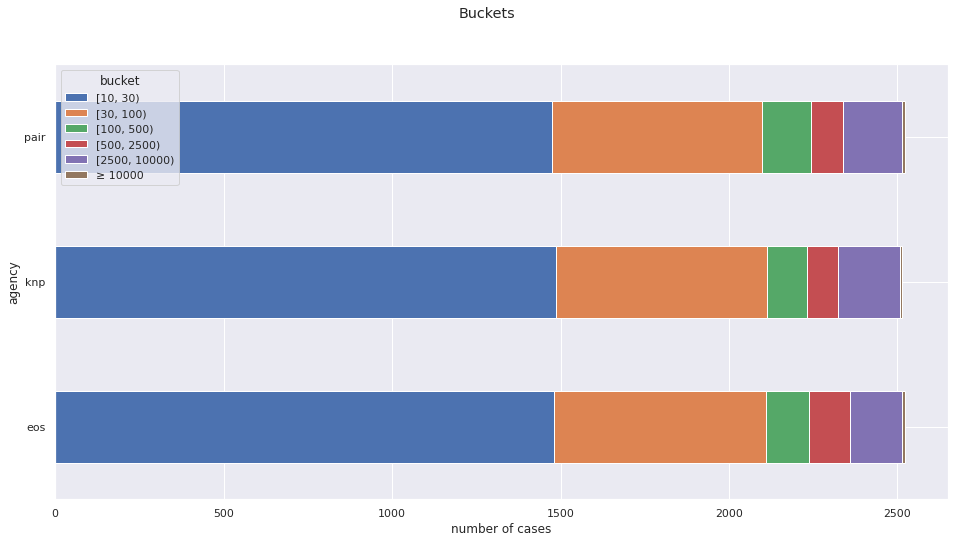

In [147]:
fig, ax = plt.subplots(nrows=1, ncols=1)

aggregated.plot(kind="barh", stacked=True, ax=ax)

ax.set_xlabel("number of cases")
fig.suptitle("Buckets")
plt.show()

In [148]:
aggregated_amt = (
    users[["agency", "bucket", "amount"]]
    .groupby(by=["agency", "bucket"])
    .sum()
    .unstack(level=-1)
)
aggregated_amt = aggregated_amt.rename(columns=bucket_dict)

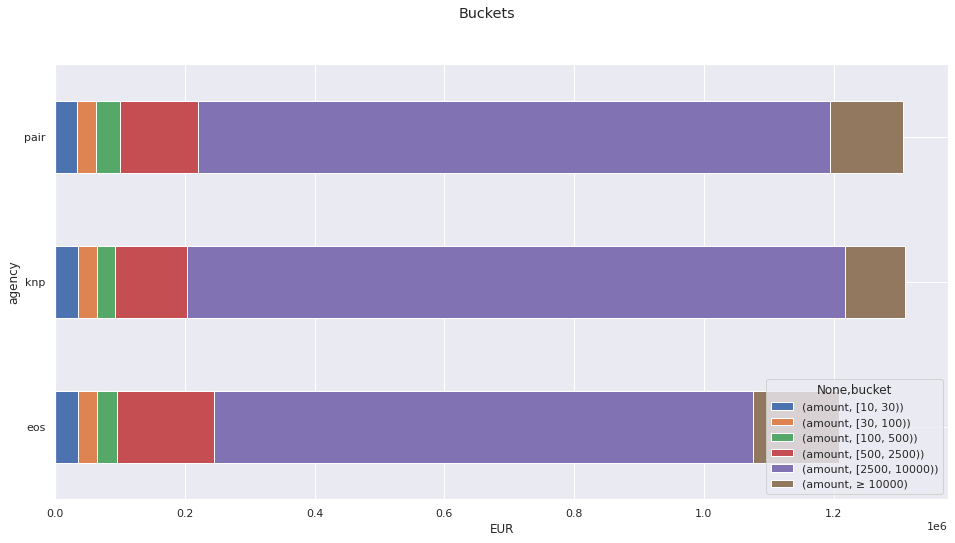

In [149]:
fig, ax = plt.subplots(nrows=1, ncols=1)

aggregated_amt.plot(kind="barh", stacked=True, ax=ax)

ax.set_xlabel("EUR")
fig.suptitle("Buckets")
plt.show()

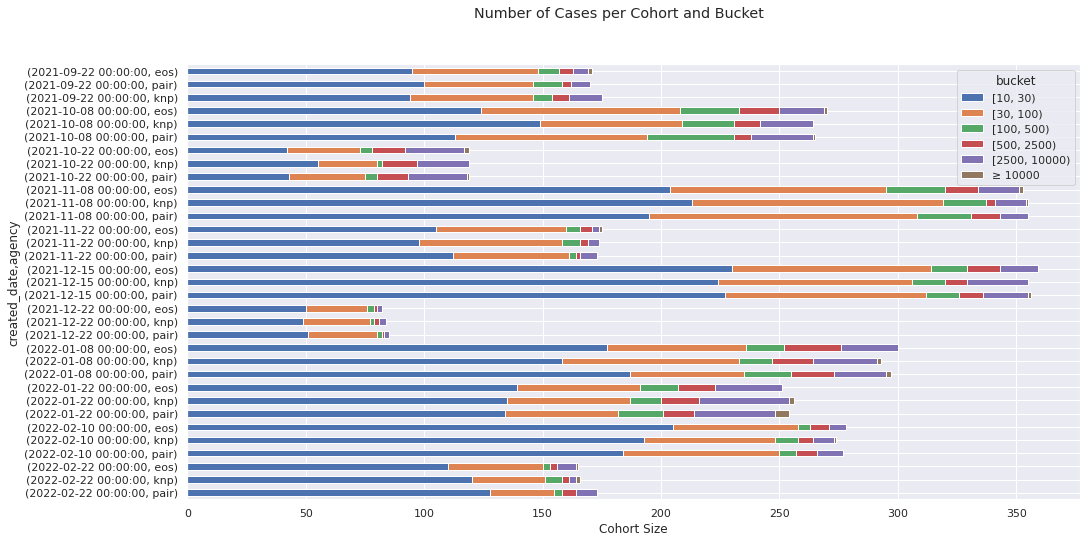

In [150]:
cohort_sizes = (
    users[["agency", "bucket", "amount", "created_date"]]
    .groupby(by=["created_date", "agency", "bucket"])
    .size()
    .unstack(level=-1)
)
cohort_sizes = cohort_sizes.rename(columns=bucket_dict)


fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(16, 8))
cohort_sizes.sort_values(by="created_date", ascending=False).plot(
    kind="barh", ax=ax, stacked=True
)
ax.set_xlabel("Cohort Size")

fig.suptitle("Number of Cases per Cohort and Bucket")
plt.show()

In [151]:
aggregated_cohorts = (
    users[["agency", "bucket", "amount", "created_date"]]
    .groupby(by=["created_date", "agency", "bucket"])
    .sum()
    .unstack(level=-1)
)
aggregated_cohorts = aggregated_cohorts.rename(columns=bucket_dict)

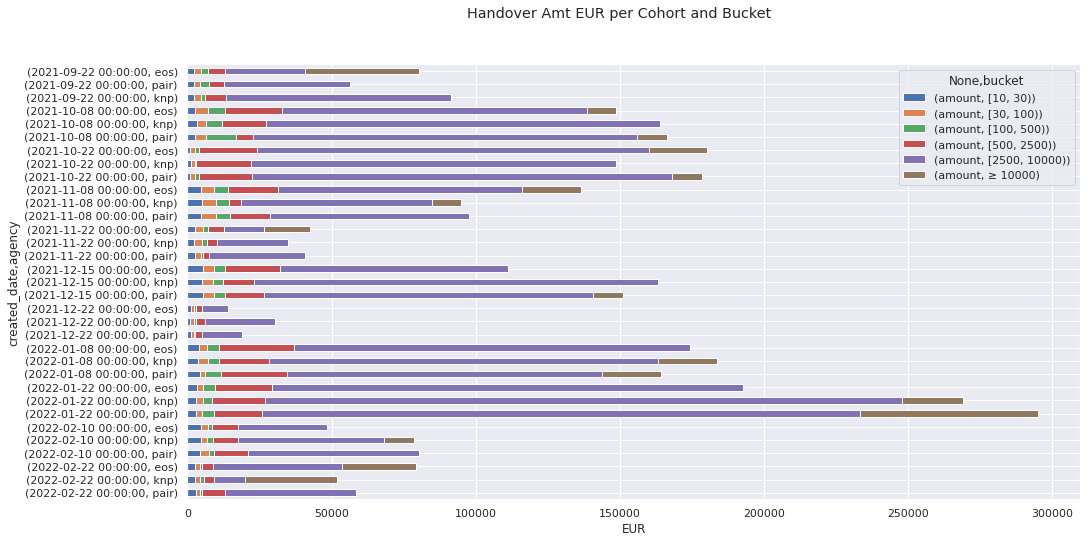

In [152]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(16, 8))
aggregated_cohorts.sort_values(by="created_date", ascending=False).plot(
    kind="barh", ax=ax, stacked=True
)
ax.set_xlabel("EUR")

fig.suptitle("Handover Amt EUR per Cohort and Bucket")
plt.show()

# Merge

In [153]:
all_data = pd.merge(all_data, users, on=["user_id", "agency", "amount"], how="inner")

In [154]:
all_data["days_diff"] = (all_data["payment_date"] - all_data["handover_date"]).dt.days

In [155]:
agg_recoveries = all_data.groupby(by=["agency", "pay_month"]).agg(
    {"payment_date": "count", "main_claim_payment": "sum"}
)

In [156]:
agg_recoveries = agg_recoveries.unstack(level=-2).rename(
    columns={"payment_date": "number_of_payments"}
)

<AxesSubplot:xlabel='pay_month'>

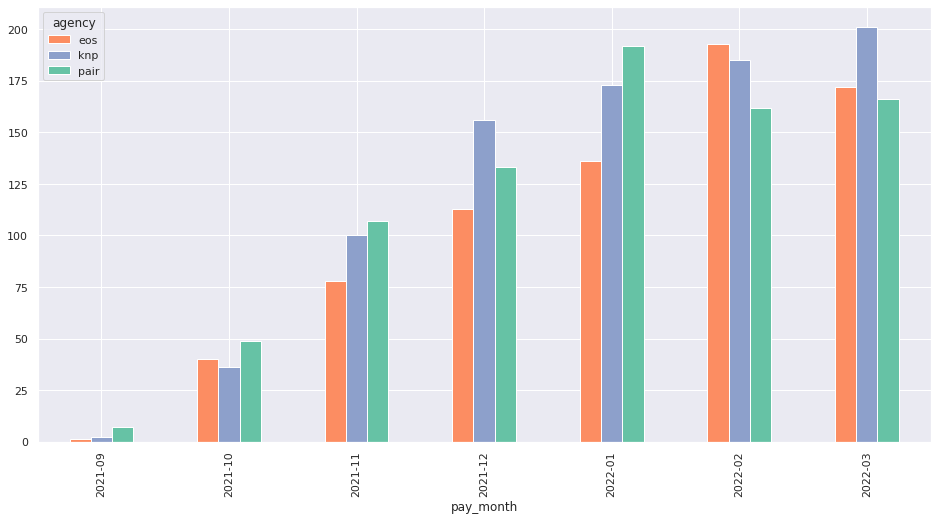

In [157]:
agg_recoveries["number_of_payments"].plot(
    kind="bar", color=agg_recoveries["number_of_payments"].columns.map(color_map)
)

<AxesSubplot:xlabel='pay_month'>

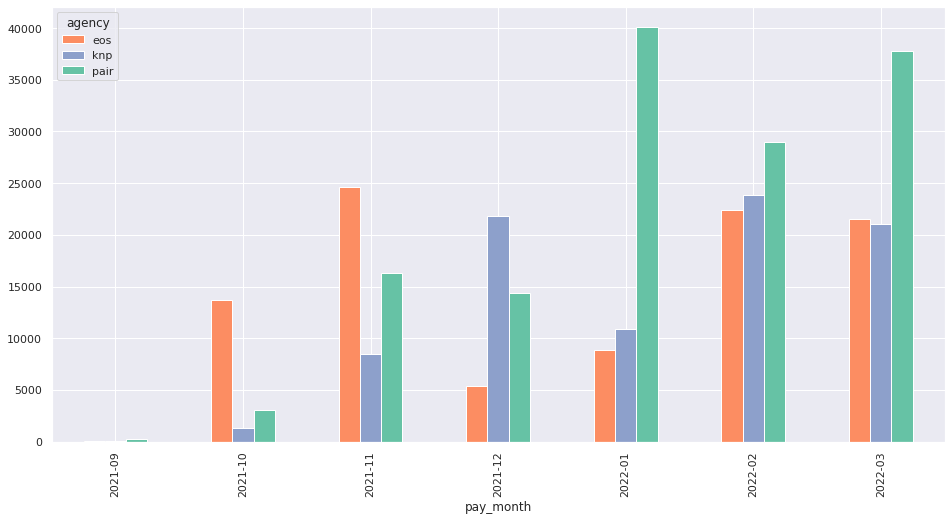

In [158]:
agg_recoveries["main_claim_payment"].plot(
    kind="bar", color=agg_recoveries["number_of_payments"].columns.map(color_map)
)

In [159]:
recoveries = (
    all_data[["main_claim_payment", "agency"]].groupby("agency").sum().squeeze()
)
fully_recovered = all_data[
    (all_data["amount"] == all_data["main_claim_payment_accumulated"])
]
handover_agg = users[["amount", "agency"]].groupby(by="agency").sum()
rates = pd.merge(handover_agg, recoveries, on="agency", how="inner")
rates["recovery_rate"] = rates.main_claim_payment / rates.amount

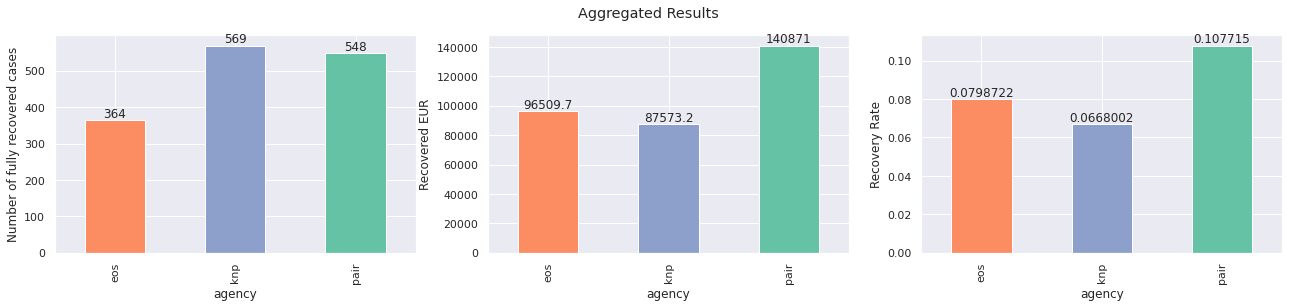

In [160]:
fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(22, 4))

y = fully_recovered[["agency", "payment_date"]].groupby(by="agency").size()


y.plot(kind="bar", color=y.index.map(color_map), ax=ax[0])
recoveries.plot(kind="bar", color=recoveries.index.map(color_map), ax=ax[1])
rates["recovery_rate"].plot(kind="bar", color=y.index.map(color_map), ax=ax[2])


for k in range(3):
    for container in ax[k].containers:
        ax[k].bar_label(container)

ax[0].set_ylabel("Number of fully recovered cases")
ax[1].set_ylabel("Recovered EUR")
ax[2].set_ylabel("Recovery Rate")
fig.suptitle("Aggregated Results")
plt.show()

In [161]:
### payments per bucket?

In [162]:
all_data.columns

Index(['mandant', 'order_number', 'Reason', 'collection_id_x', 'user_id',
       'claim_number', 'phase', 'handover_date', 'collection_status', 'action',
       'amount', 'main_claim_basis', 'is_instalment_plan', 'instalment_status',
       'instalment_agreed_n', 'instalment_agreed_amount', 'main_claim_payment',
       'main_claim_open', 'payment_date', 'main_claim_payment_accumulated',
       'agency', 'debt_type_x', 'pay_month', 'date', 'created', 'is_credit',
       'debt_type_y', 'collection_id_y', 'created_date', 'bucket',
       'days_diff'],
      dtype='object')

## First Payment, Complete Payment

In [163]:
first_payment = (
    all_data[["agency", "user_id", "days_diff", "amount", "debt_type_y"]]
    .groupby(by=["agency", "user_id", "amount", "debt_type_y"])
    .min()
    .reset_index()
)

/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:11: UserWarning: Legend does not support <AxesSubplot:title={'center':'pair'}, xlabel='days'> instances.
A proxy artist may be used instead.
See: https://matplotlib.org/users/legend_guide.html#creating-artists-specifically-for-adding-to-the-legend-aka-proxy-artists
  # This is added back by InteractiveShellApp.init_path()
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:11: UserWarning: Legend does not support <AxesSubplot:title={'center':'knp'}, xlabel='days'> instances.
A proxy artist may be used instead.
See: https://matplotlib.org/users/legend_guide.html#creating-artists-specifically-for-adding-to-the-legend-aka-proxy-artists
  # This is added back by InteractiveShellApp.init_path()
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:11: UserWarning: Legend does not support <AxesSubplot:title={'center':'eos'}, xlabel='days'> instances.
A proxy artist may be used instead.
See: https://matplotlib.org/us

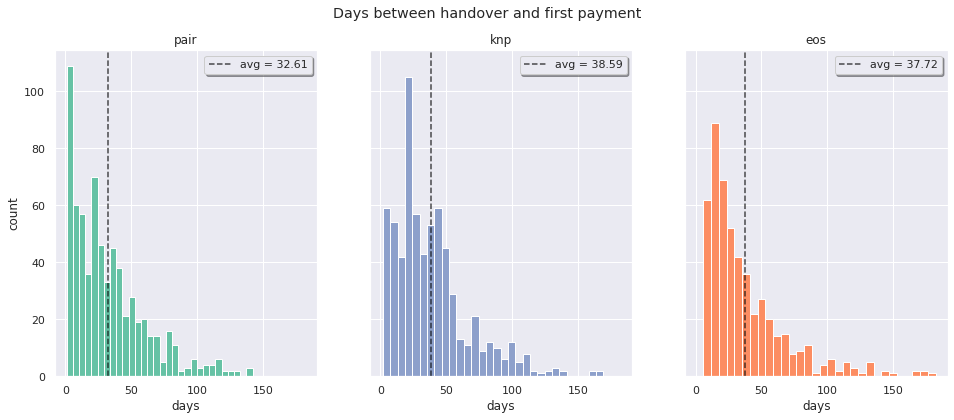

In [164]:
fig, ax = plt.subplots(nrows=1, ncols=3, sharex=True, sharey=True, figsize=(16, 6))
k = 0

for ag in list(set(first_payment.agency)):
    mean = round(first_payment[first_payment.agency == ag]["days_diff"].mean(), 2)
    hist = first_payment[first_payment.agency == ag]["days_diff"].hist(
        ax=ax[k], color=color_map.get(ag), bins=30
    )
    line = ax[k].axvline(x=mean, color="black", linestyle="--", alpha=0.7)
    ax[k].set_title(ag)
    ax[k].set_xlabel("days")
    ax[k].legend(
        (hist, line), ("days", f"avg = {mean}"), loc="upper right", shadow=True
    )
    k += 1

ax[0].set_ylabel("count")
fig.suptitle("Days between handover and first payment")
plt.show()

## Cumulative Payments

In [165]:
cumulative_payments = (
    all_data[["agency", "payment_date", "main_claim_payment"]]
    .groupby(["agency", "payment_date"])
    .sum()
    .sort_values(by=["agency", "payment_date"])
    .groupby(["agency"])
    .cumsum()
    .reset_index()
)
cumulative_payments["payment_date"] = pd.to_datetime(
    cumulative_payments["payment_date"]
)

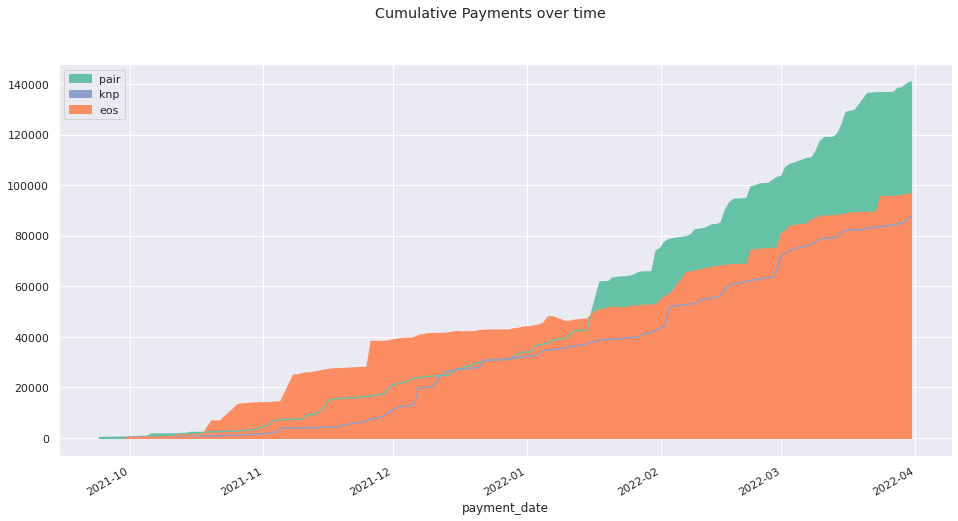

In [166]:
fig, ax = plt.subplots(nrows=1, ncols=1)


for ag in list(set(cumulative_payments.agency)):
    cumulative_payments[cumulative_payments.agency == ag].plot(
        kind="area",
        x="payment_date",
        y="main_claim_payment",
        ax=ax,
        label=ag,
        color=color_map.get(ag),
    )

fig.suptitle("Cumulative Payments over time")
plt.show()

In [167]:
cumulative_payments = pd.merge(
    cumulative_payments, handover_agg, on="agency", how="inner"
)

In [168]:
cumulative_payments["cumulative_recovery_rate"] = (
    cumulative_payments.main_claim_payment / cumulative_payments.amount
)

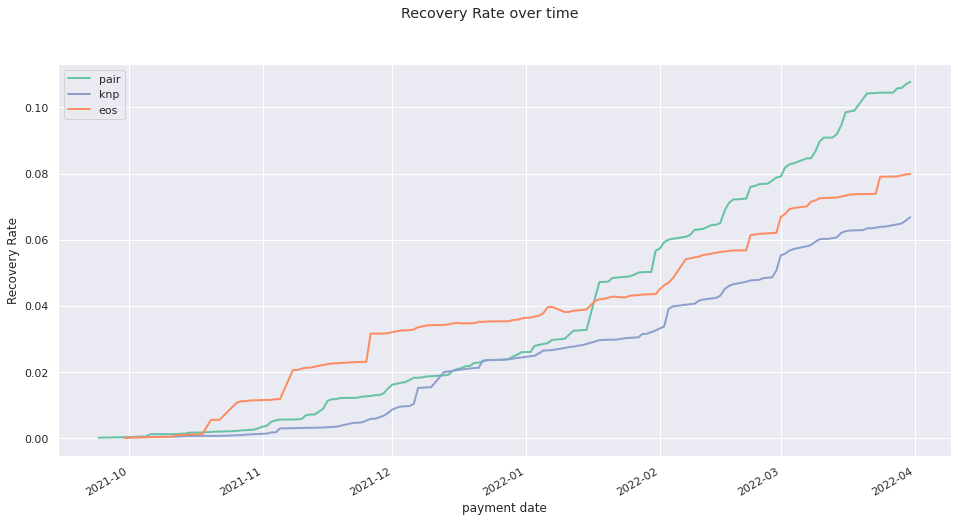

In [169]:
fig, ax = plt.subplots(nrows=1, ncols=1)

for ag in list(set(cumulative_payments.agency)):
    cumulative_payments[cumulative_payments.agency == ag].plot(
        ax=ax,
        x="payment_date",
        y="cumulative_recovery_rate",
        label=ag,
        color=color_map.get(ag),
        linewidth=2,
    )

ax.set_xlabel("payment date")
ax.set_ylabel("Recovery Rate")
fig.suptitle("Recovery Rate over time")
plt.show()

## Recoveries per Cohort

In [170]:
cohort_base_amts = (
    users[["agency", "amount", "created_date"]]
    .groupby(by=["created_date", "agency"])
    .sum()
)
cohort_recoveries = (
    all_data[["agency", "created_date", "main_claim_payment"]]
    .groupby(by=["created_date", "agency"])
    .sum()
)
cohort_recoveries = pd.merge(
    cohort_recoveries, cohort_base_amts, on=["created_date", "agency"], how="inner"
)

In [171]:
cohort_recoveries["recovery_rate"] = (
    cohort_recoveries["main_claim_payment"] / cohort_recoveries["amount"]
)

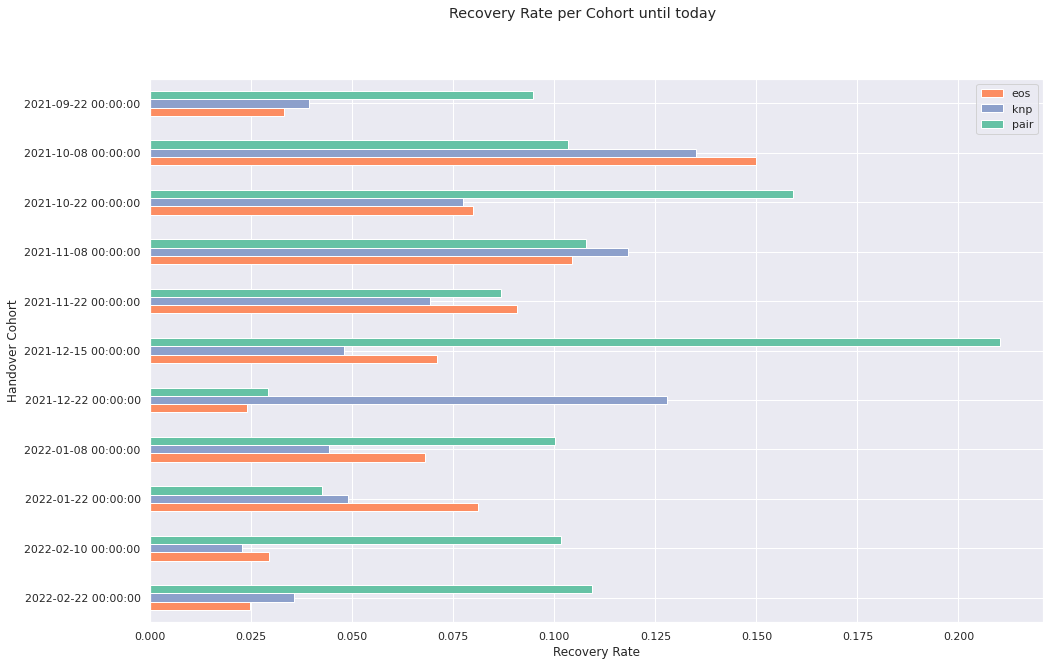

In [172]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(16, 10))
y = (
    cohort_recoveries[["recovery_rate"]]
    .unstack()
    .sort_values(by="created_date", ascending=False)
)
y.plot(
    kind="barh",
    ax=ax,
    color=(
        (0.9882352941176471, 0.5529411764705883, 0.3843137254901961),
        (0.5529411764705883, 0.6274509803921569, 0.796078431372549),
        (0.4, 0.7607843137254902, 0.6470588235294118),
    ),
)
ax.set_xlabel("Recovery Rate")
ax.set_ylabel("Handover Cohort")
ax.legend(labels=("eos", "knp", "pair"))
fig.suptitle("Recovery Rate per Cohort until today")
plt.show()

## Cumulative Payments Per Cohort

In [173]:
cumulative_payments_per_cohort = (
    all_data[["agency", "created_date", "payment_date", "main_claim_payment"]]
    .groupby(["agency", "created_date", "payment_date"])
    .sum()
    .sort_values(by=["agency", "created_date", "payment_date"])
    .groupby(["created_date", "agency"])
    .cumsum()
    .reset_index()
)

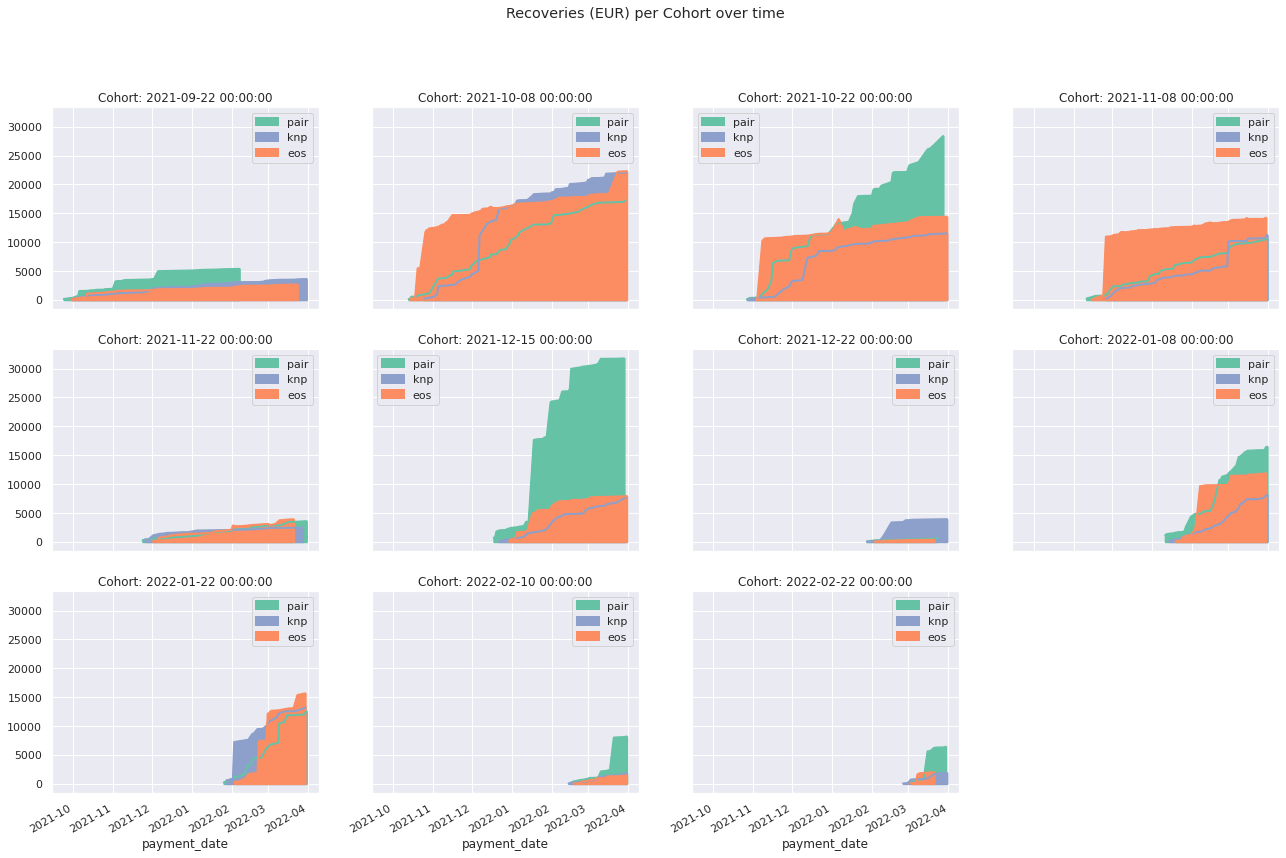

In [305]:
fig, ax = plt.subplots(nrows=3, ncols=4, sharex=True, sharey=True, figsize=(22, 14))

for i, k in enumerate(sorted(list(set(cumulative_payments_per_cohort.created_date)))):
    # we map 1d-array (created_dates) to 2d-array ax:
    row_index = int(i / 4)
    column_index = int(i % 4)
    ax[row_index][column_index].set_title(f"Cohort: {k}")

    for ag in list(set(cumulative_payments.agency)):
        cumulative_payments_per_cohort[
            (cumulative_payments_per_cohort.created_date == k)
            & (cumulative_payments_per_cohort.agency == ag)
        ].plot(
            kind="area",
            ax=ax[row_index][column_index],
            x="payment_date",
            y="main_claim_payment",
            label=ag,
            color=color_map.get(ag),
            linewidth=2,
        )

fig.delaxes(ax[2][3])
fig.suptitle("Recoveries (EUR) per Cohort over time")
plt.show()

## Recovery Rates Per Cohort


In [175]:
handover_agg_per_cohort = (
    users[["amount", "agency", "created_date"]]
    .groupby(by=["created_date", "agency"])
    .sum()
    .reset_index()
)

In [176]:
cumulative_payments_per_cohort["created_date"] = cumulative_payments_per_cohort[
    "created_date"
].astype(str)
handover_agg_per_cohort["created_date"] = handover_agg_per_cohort[
    "created_date"
].astype(str)

In [177]:
cumulative_payments_per_cohort = pd.merge(
    cumulative_payments_per_cohort,
    handover_agg_per_cohort,
    on=["created_date", "agency"],
    how="right",
)
cumulative_payments_per_cohort["created_date"] = pd.to_datetime(
    cumulative_payments_per_cohort["created_date"]
)

In [178]:
cumulative_payments_per_cohort["recovery_rate"] = (
    cumulative_payments_per_cohort.main_claim_payment
    / cumulative_payments_per_cohort.amount
)

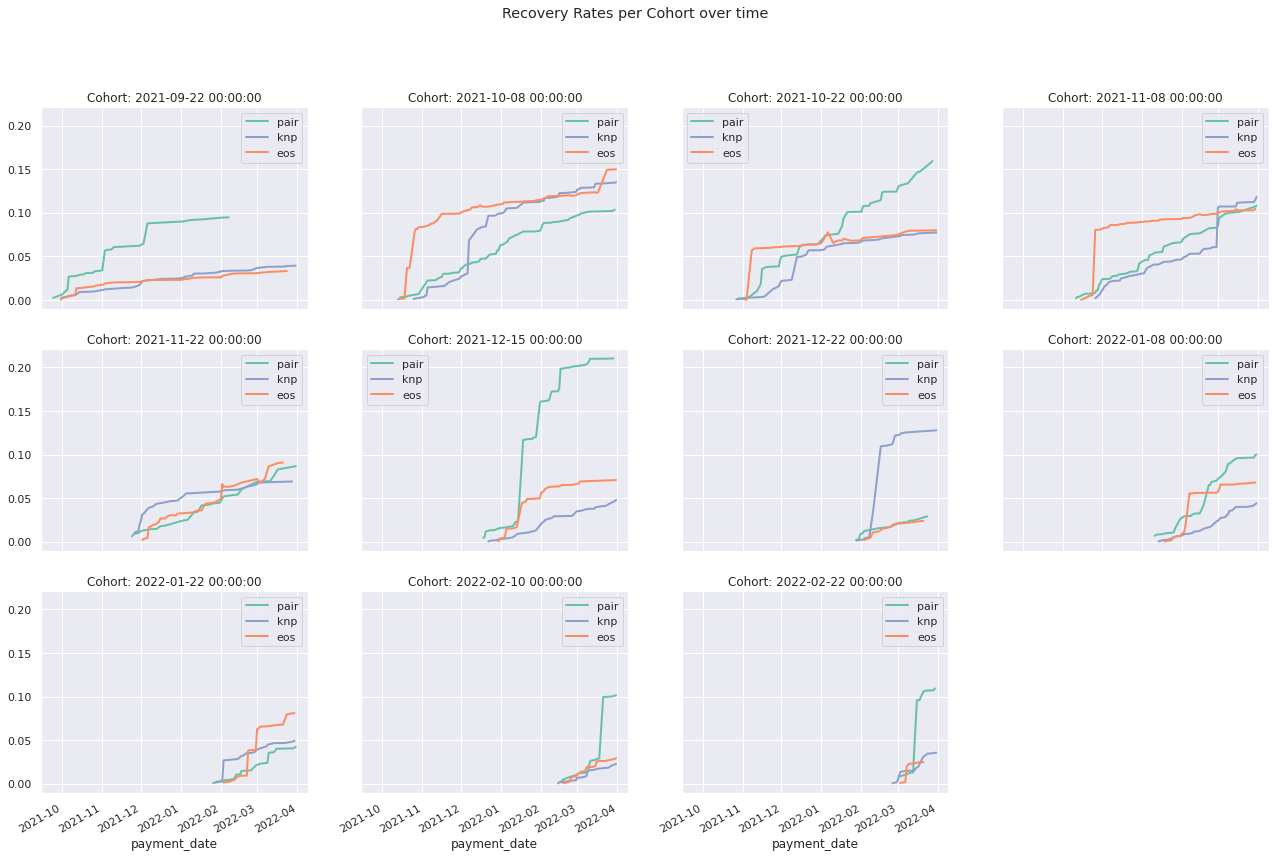

In [304]:
fig, ax = plt.subplots(nrows=3, ncols=4, sharex=True, sharey=True, figsize=(22, 14))

for i, k in enumerate(sorted(list(set(cumulative_payments_per_cohort.created_date)))):
    # we map 1d-array (created_dates) to 2d-array ax:
    row_index = int(i / 4)
    column_index = int(i % 4)
    ax[row_index][column_index].set_title(f"Cohort: {k}")

    for ag in list(set(cumulative_payments.agency)):
        cumulative_payments_per_cohort[
            (cumulative_payments_per_cohort.created_date == k)
            & (cumulative_payments_per_cohort.agency == ag)
        ].plot(
            ax=ax[row_index][column_index],
            x="payment_date",
            y="recovery_rate",
            label=ag,
            color=color_map.get(ag),
            linewidth=2,
        )

fig.delaxes(ax[2][3])
fig.suptitle("Recovery Rates per Cohort over time")
plt.show()

## Recovered Cases per Cohort

In [180]:
cumulative_fully_recovered_cases_per_cohort = (
    fully_recovered[["agency", "created_date", "payment_date", "main_claim_payment"]]
    .groupby(["agency", "created_date", "payment_date"])
    .count()
    .sort_values(by=["agency", "created_date", "payment_date"])
    .groupby(["created_date", "agency"])
    .cumsum()
    .reset_index()
)

In [181]:
handover_cnt_per_cohort = (
    users[["amount", "agency", "created_date"]]
    .groupby(by=["created_date", "agency"])
    .count()
    .reset_index()
)

# for the join to work
cumulative_fully_recovered_cases_per_cohort[
    "created_date"
] = cumulative_fully_recovered_cases_per_cohort["created_date"].astype(str)
handover_cnt_per_cohort["created_date"] = handover_cnt_per_cohort[
    "created_date"
].astype(str)

In [182]:
cumulative_fully_recovered_cases_per_cohort = pd.merge(
    cumulative_fully_recovered_cases_per_cohort,
    handover_cnt_per_cohort,
    on=["created_date", "agency"],
    how="right",
)

cumulative_fully_recovered_cases_per_cohort["created_date"] = pd.to_datetime(
    cumulative_fully_recovered_cases_per_cohort["created_date"]
)

In [183]:
cumulative_fully_recovered_cases_per_cohort["share_recovered_cases"] = (
    cumulative_fully_recovered_cases_per_cohort.main_claim_payment
    / cumulative_fully_recovered_cases_per_cohort.amount
)

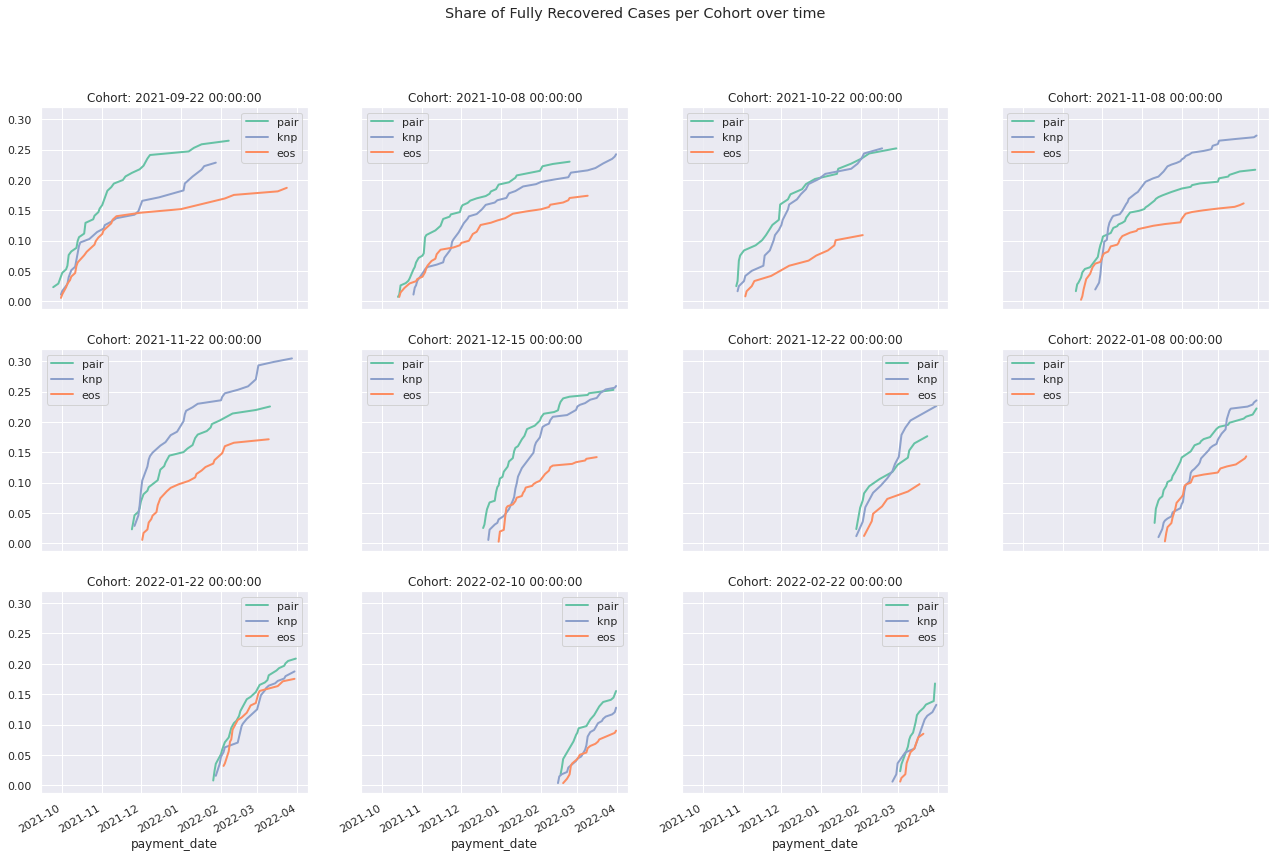

In [307]:
fig, ax = plt.subplots(nrows=3, ncols=4, sharex=True, sharey=True, figsize=(22, 14))

for i, k in enumerate(
    sorted(list(set(cumulative_fully_recovered_cases_per_cohort.created_date)))
):
    # we map 1d-array (created_dates) to 2d-array ax:
    row_index = int(i / 4)
    column_index = int(i % 4)
    ax[row_index][column_index].set_title(f"Cohort: {k}")

    for ag in list(set(cumulative_payments.agency)):
        cumulative_fully_recovered_cases_per_cohort[
            (cumulative_fully_recovered_cases_per_cohort.created_date == k)
            & (cumulative_fully_recovered_cases_per_cohort.agency == ag)
        ].plot(
            ax=ax[row_index][column_index],
            x="payment_date",
            y="share_recovered_cases",
            label=ag,
            color=color_map.get(ag),
            linewidth=2,
        )

fig.delaxes(ax[2][3])
fig.suptitle("Share of Fully Recovered Cases per Cohort over time")
plt.show()

## Recovery Rate Per Bucket

In [185]:
rec_bucket = (
    all_data[["agency", "bucket", "main_claim_payment"]]
    .groupby(by=["agency", "bucket"])
    .sum()
    .reset_index()
)
handover_bucket = (
    users[["agency", "bucket", "amount"]]
    .groupby(by=["agency", "bucket"])
    .sum()
    .reset_index()
)

In [186]:
rec_bucket = pd.merge(rec_bucket, handover_bucket, on=["agency", "bucket"])

In [187]:
rec_bucket["recovery_rate"] = rec_bucket["main_claim_payment"] / rec_bucket["amount"]

In [188]:
rec_bucket = (
    rec_bucket[["agency", "bucket", "recovery_rate"]]
    .groupby(by=["agency", "bucket"])
    .mean()
)

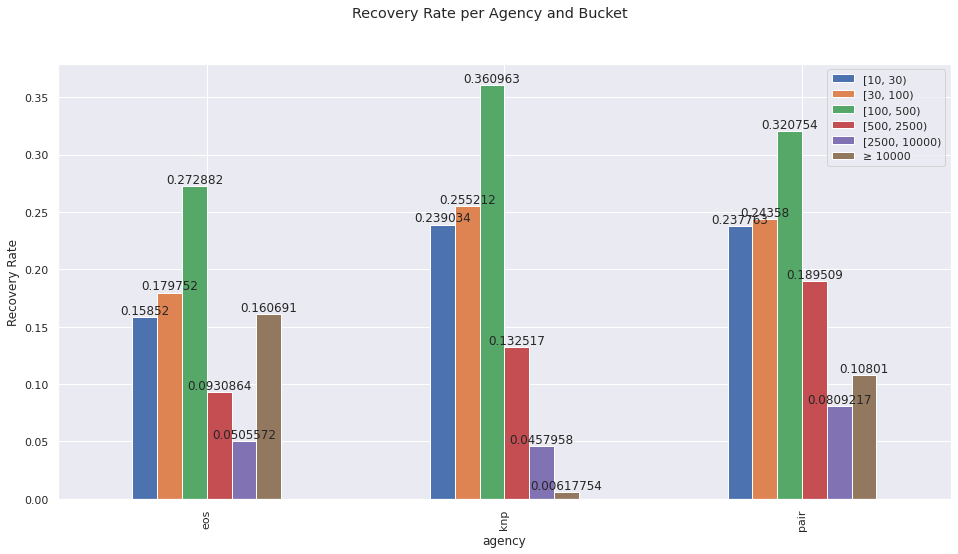

In [189]:
fig, ax = plt.subplots(nrows=1, ncols=1)
rec_bucket.unstack(-1).rename(columns=bucket_dict).plot(kind="bar", ax=ax)

ax.set_ylabel("Recovery Rate")
for container in ax.containers:
    ax.bar_label(container)
ax.legend(labels=buckets)
fig.suptitle("Recovery Rate per Agency and Bucket")
plt.show()

## Speed of Action Per Bucket

/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:21: UserWarning: Legend does not support <AxesSubplot:title={'center':'Bucket 0, pair'}> instances.
A proxy artist may be used instead.
See: https://matplotlib.org/users/legend_guide.html#creating-artists-specifically-for-adding-to-the-legend-aka-proxy-artists
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:21: UserWarning: Legend does not support <AxesSubplot:title={'center':'Bucket 0, knp'}> instances.
A proxy artist may be used instead.
See: https://matplotlib.org/users/legend_guide.html#creating-artists-specifically-for-adding-to-the-legend-aka-proxy-artists
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:21: UserWarning: Legend does not support <AxesSubplot:title={'center':'Bucket 0, eos'}> instances.
A proxy artist may be used instead.
See: https://matplotlib.org/users/legend_guide.html#creating-artists-specifically-for-adding-to-the-legend-aka-proxy-artists
/usr/local/lib/python3.7/site-packag

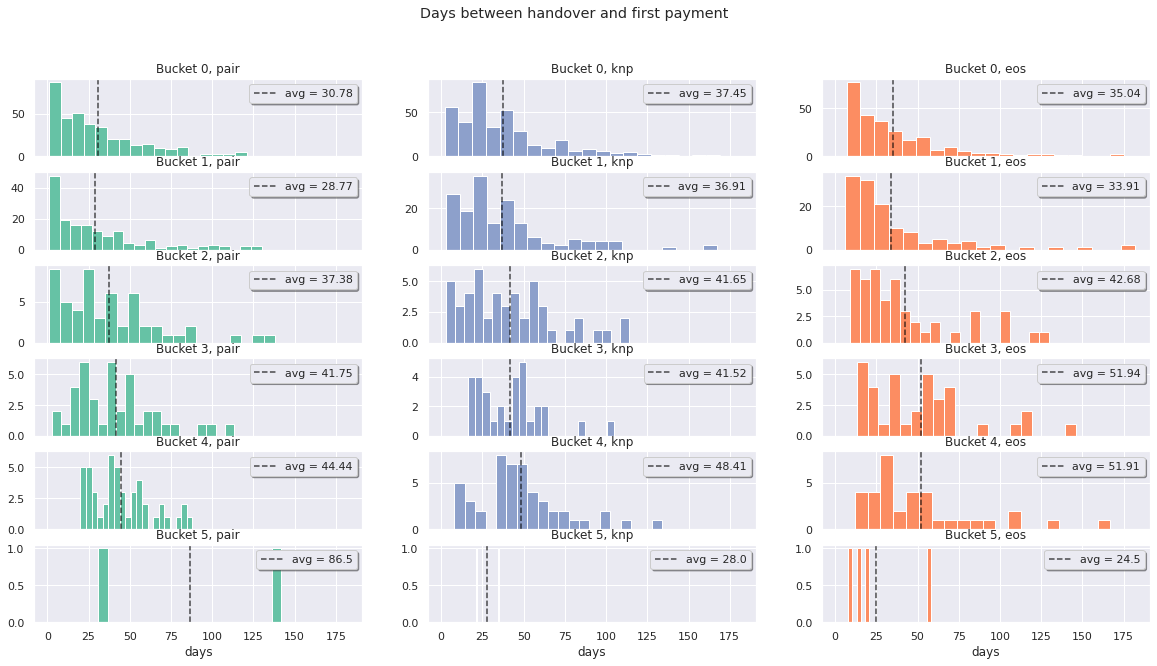

In [425]:
first_payment2 = (
    all_data[["agency", "user_id", "days_diff", "amount", "debt_type_y", "bucket"]]
    .groupby(by=["agency", "user_id", "amount", "debt_type_y", "bucket"])
    .min()
    .reset_index()
)
fig, ax = plt.subplots(nrows=6, ncols=3, sharex=True, sharey=False, figsize=(20, 10))

j = 0
k = 0

for j, bu in enumerate(sorted(list(set(first_payment2.bucket)))):
    for k, ag in enumerate(list(set(first_payment2.agency))):
        mean = round(
            first_payment2[
                (first_payment2.agency == ag) & (first_payment2.bucket == bu)
            ]["days_diff"].mean(),
            2,
        )
        hist = first_payment2[
            (first_payment2.agency == ag) & (first_payment2.bucket == bu)
        ]["days_diff"].hist(
            ax=ax[j][k], color=color_map.get(ag), bins=20, density=False
        )
        line = ax[j][k].axvline(x=mean, color="black", linestyle="--", alpha=0.7)
        ax[j][k].set_title(f"Bucket {bu}, {ag}")

        ## add label to bottom row only

        if j == 5:
            ax[j][k].set_xlabel("days")
        else:
            ax[j][k].set_xlabel("")

        ax[j][k].legend(
            (hist, line), ("days", f"avg = {mean}"), loc="upper right", shadow=True
        )


# ax[0].set_ylabel('count')
fig.suptitle("Days between handover and first payment")
plt.show()

## Largest Payments per Agency

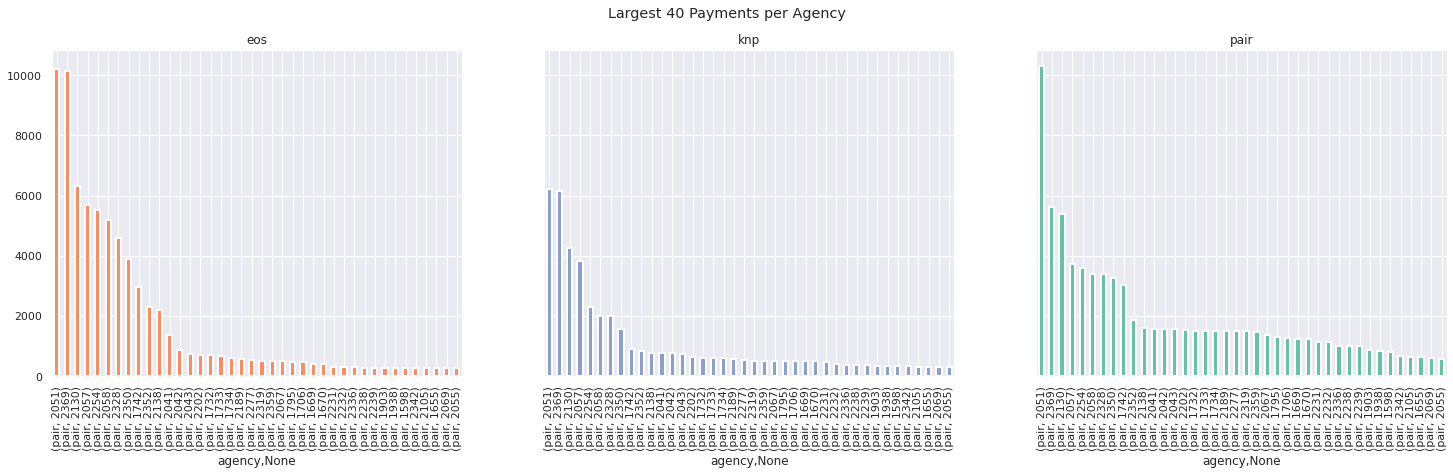

In [234]:
y = (
    all_data[["agency", "main_claim_payment"]]
    .groupby("agency")
    .apply(lambda grp: grp.nlargest(40, "main_claim_payment"))
)

fig, ax = plt.subplots(nrows=1, ncols=3, sharex=True, sharey=True, figsize=(25, 6))

for i, ag in enumerate(sorted(list(set(all_data.agency)))):
    # we map 1d-array (created_dates) to 2d-array ax:
    ax[i].set_title(ag)
    y[y.agency == ag]["main_claim_payment"].plot(
        kind="bar",
        ax=ax[i],
        y="main_claim_payment",
        label=None,
        color=color_map.get(ag),
        linewidth=2,
    )


fig.suptitle("Largest 40 Payments per Agency")
plt.show()

In [277]:
z = (
    all_data[["agency", "main_claim_payment"]]
    .groupby(by="agency")
    .rank("dense", ascending=False)
    .rename(columns={"main_claim_payment": "rank"})
)
ranked = pd.merge(
    all_data[["agency", "main_claim_payment"]],
    z,
    left_index=True,
    right_index=True,
    how="inner",
)
ranked = ranked.set_index("rank").sort_index()

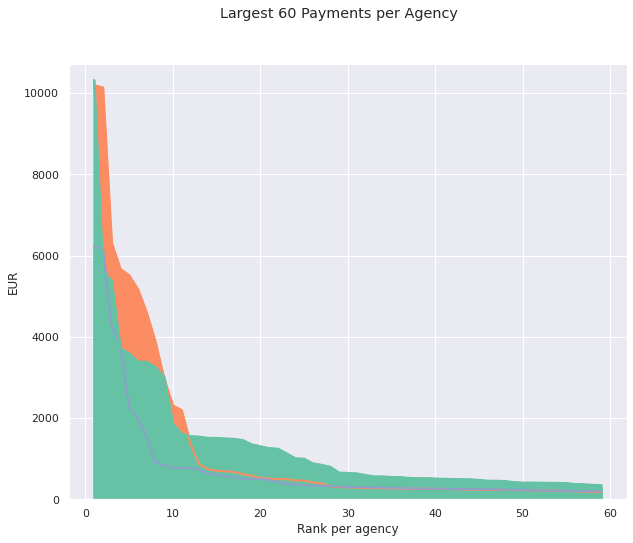

In [424]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(10, 8))

for i, ag in enumerate(sorted(list(set(all_data.agency)))):
    # we map 1d-array (created_dates) to 2d-array ax:
    ranked[(ranked.agency == ag) & (ranked.index < 60)]["main_claim_payment"].plot(
        kind="area",
        ax=ax,
        y="main_claim_payment",
        label=ag,
        color=color_map.get(ag),
        linewidth=2,
    )

ax.set_xlabel("Rank per agency")
ax.set_ylabel("EUR")
fig.suptitle("Largest 60 Payments per Agency")
plt.show()

### Sensitivity of Recovery Rate to Large Payments

In [313]:
from scipy.stats import zscore

In [ ]:
recoveries2 = (
    all_data[all_data.index != 1652][["main_claim_payment", "agency"]]
    .groupby("agency")
    .sum()
    .squeeze()
)
handover_agg2 = (
    users[users.user_id != "2eb0dd97-920a-4afb-8f49-270f8f3ec031"][["amount", "agency"]]
    .groupby(by="agency")
    .sum()
)

In [358]:
y = all_data[["main_claim_payment", "agency", "user_id"]]
y.main_claim_payment.quantile(0.990)

2192.9608999999573

In [359]:
rem_top_percent = y[y.main_claim_payment < y.main_claim_payment.quantile(0.99)]

### removing data above 99-th quantile means removing top 25 payments 

In [402]:
print(
    len(
        y[y.main_claim_payment >= y.main_claim_payment.quantile(0.99)].sort_values(
            by="main_claim_payment", ascending=False
        )
    )
)
largest_recoveries = y[
    y.main_claim_payment >= y.main_claim_payment.quantile(0.99)
].sort_values(by="main_claim_payment", ascending=False)

25


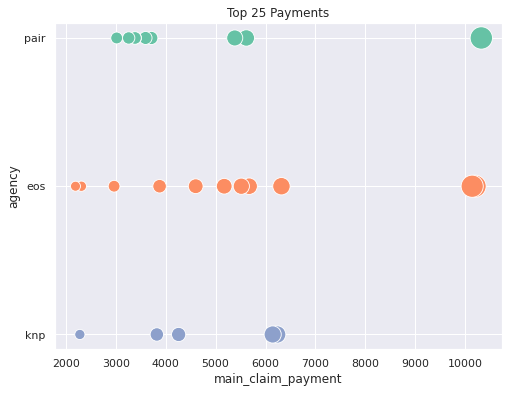

In [422]:
sns.set(rc={"figure.figsize": (8, 6)})
g = sns.scatterplot(
    data=largest_recoveries[["main_claim_payment", "agency"]],
    x="main_claim_payment",
    y="agency",
    hue="agency",
    size="main_claim_payment",
    sizes=(100, 500),
    palette=color_map,
)
plt.title("Top 25 Payments")
plt.legend([], frameon=False)

In [399]:
recoveries2 = (
    rem_top_percent[["main_claim_payment", "agency"]].groupby("agency").sum().squeeze()
)
handover_agg2 = users[["amount", "agency"]].groupby(by="agency").sum()

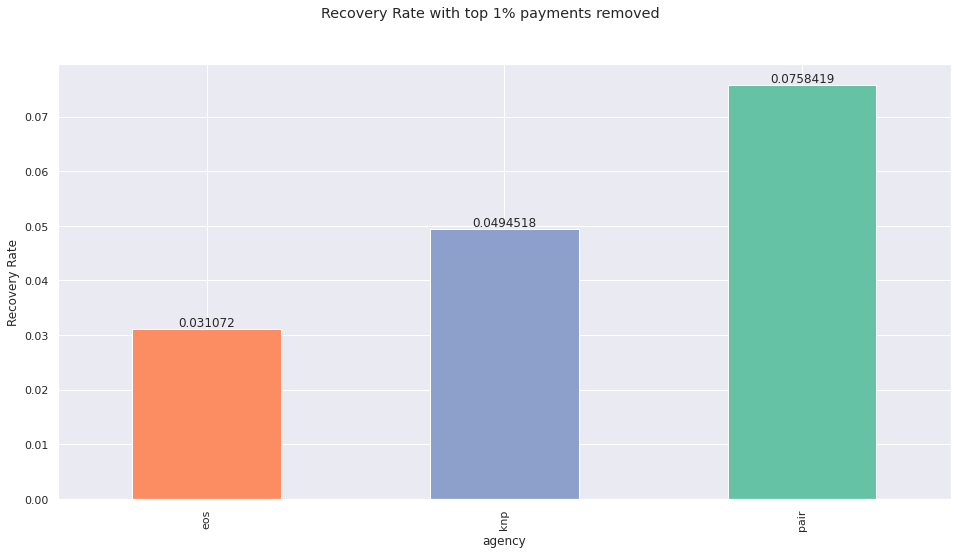

In [401]:
rates2 = pd.merge(handover_agg2, recoveries2, on="agency", how="inner")
rates2["recovery_rate"] = rates2.main_claim_payment / rates2.amount
fig, ax = plt.subplots(nrows=1, ncols=1)

ax = rates2["recovery_rate"].plot(kind="bar", color=rates2.index.map(color_map))

for container in ax.containers:
    ax.bar_label(container)

ax.set_ylabel("Recovery Rate")
fig.suptitle("Recovery Rate with top 1% payments removed")
plt.show()